In [1]:
# -*- coding: utf-8 -*-
# @ Time    : 2024/10/06
# @ Author : zlz.bit.pro@gmail.com
# @ Desc: Example to process wiki_ts dataset

import os
workspace_path = '../..'
os.chdir(workspace_path)
print("Current workspace:", os.getcwd())

import numpy as np
from neuralbench.index.util import load_key_set, KeyType, save_file
from neuralbench.index.bench import KeySetBinEncoder, sample_bulkloading_keyset
from neuralbench.drift import find_q

Current workspace: /users/lingze/neurbench


In [4]:
# load wiki_ts_200M key set
# keyset_file_path = "/users/lingze/TLI/data/wiki_ts_200M_uint64"
# data = load_key_set(keyset_file_path)

In [5]:
# get data type and check whether unique
# data_type = KeyType.resolve_type_from_filename(keyset_file_path)
# print(data_type)
# flag = len(np.unique(data)) == len(data)
# print("Data is unique:", flag)

KeyType.UINT64
Data is unique: False


In [6]:
# save the unique data in the keys
# unique_data = np.unique(data)
# keyset_output_file_path = "/users/lingze/TLI/data/wiki_ts_200M_unique_uint64"
# save_file(keyset_output_file_path, unique_data, data_type)

In [2]:
# load wiki_ts_unique_200M_uint64 key set
keyset_file_path = "/users/lingze/TLI/data/wiki_ts_200M_unique_uint64"
data = load_key_set(keyset_file_path)

In [3]:
# get data type and check whether unique
data_type = KeyType.resolve_type_from_filename(keyset_file_path)
print(data_type)
flag = len(np.unique(data)) == len(data)
print("Data is unique:", flag)

KeyType.UINT64
Data is unique: True


Max value: 1216240436
Min value: 979672113


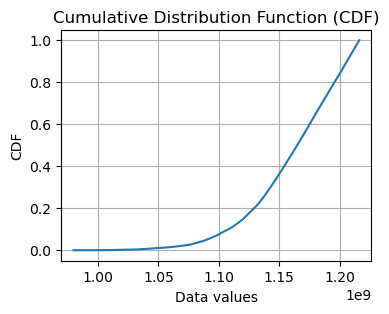

In [6]:
"""plot the data Cumulative Distribution Function (CDF)
"""
max_value = np.max(data)
min_value = np.min(data)
print("Max value:", max_value)
print("Min value:", min_value)
KeySetBinEncoder.plot_cdf(
    data,
    min_value=min_value,
    max_value=max_value,
    offset= 1e7,
)

In [7]:
"""abnormal key filter
# before we get the data distribution of key set
# we need to filter out the abnormal keys
"""
keys, removed_key = KeySetBinEncoder.filter_abnormal_values(data, "IQR", verbose = True)
print("Remove rate:", len(removed_key) / len(data))

Filtered 1150206 values, [89286805 / 90437011]
Remove rate: 0.012718310648280934


Total number of bins: 154


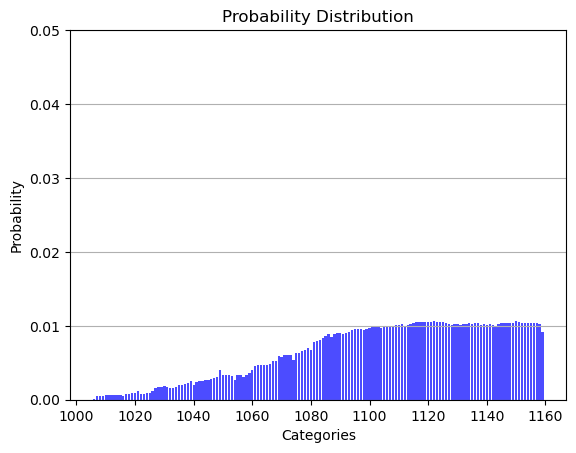

In [11]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 20
bin_idxs, prob, bin_idx_to_keys = KeySetBinEncoder.bin_keyset_to_distribution(
    keys,
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(prob, bin_idxs.tolist())

In [12]:
min_bin_num = int(np.min(bin_idxs))
max_bin_num = int(np.max(bin_idxs))
prob_dict = {}

for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = prob[i]

x = [ i for i in range(min_bin_num, max_bin_num+1)]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.02


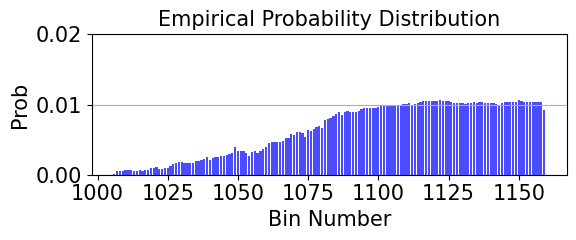

In [14]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('Bin Number', fontsize = 15)
ax.set_ylabel('Prob', fontsize = 15)
ax.set_title('Empirical Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, 0.02)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/wiki_ts_200M_uint64_distribution.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

---
### Drift 0.1

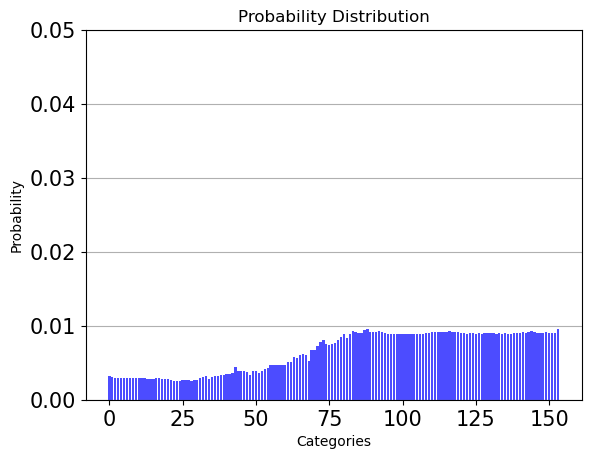

In [15]:
# Drift setting alpha = 0.1, unform drift
init_prob = find_q(prob, 0.1, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [16]:
bulkloading_n = int(0.5 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 1006, sample_n: 141696, bound_n: 11973
Exceeding the number of keys in bin 1007, sample_n: 134742, bound_n: 43146
Exceeding the number of keys in bin 1008, sample_n: 133566, bound_n: 48879
Exceeding the number of keys in bin 1009, sample_n: 133461, bound_n: 49394
Exceeding the number of keys in bin 1010, sample_n: 131235, bound_n: 60659
Exceeding the number of keys in bin 1011, sample_n: 131655, bound_n: 58495
Exceeding the number of keys in bin 1012, sample_n: 131419, bound_n: 59708
Exceeding the number of keys in bin 1013, sample_n: 132704, bound_n: 53164
Exceeding the number of keys in bin 1014, sample_n: 132743, bound_n: 52969
Exceeding the number of keys in bin 1015, sample_n: 131628, bound_n: 58634
Exceeding the number of keys in bin 1016, sample_n: 133192, bound_n: 50727
Exceeding the number of keys in bin 1017, sample_n: 130675, bound_n: 63576
Exceeding the number of keys in bin 1018, sample_n: 130558, bound_n: 64190
Exceeding the number of k

Total number of bins: 154


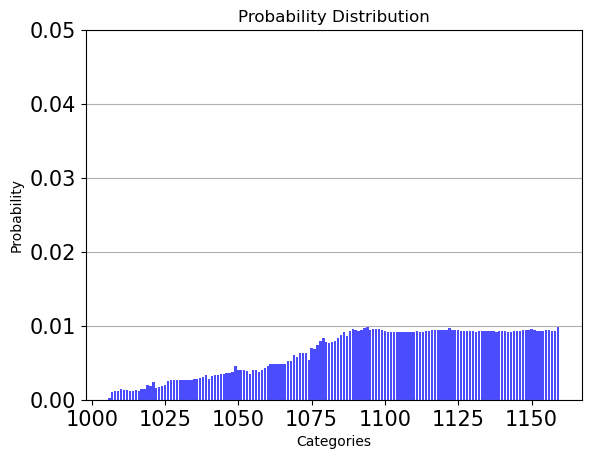

In [17]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 20
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

In [18]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))

Insert number of records: 47173895
Insert ratio: 0.5216215626586774


In [19]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.1


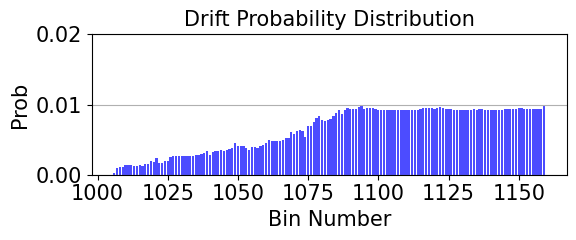

In [21]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 10) / 10
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('Bin Number', fontsize = 15)
ax.set_ylabel('Prob', fontsize = 15)
ax.set_title('Drift Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, 0.02)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/wiki_ts_200M_uint64_distribution_drift_01.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [22]:
workload_dir_path = "/users/lingze/neurbench/data/workload/wiki_ts_200M_uint64_drift_01"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

---
### Drift 0.3

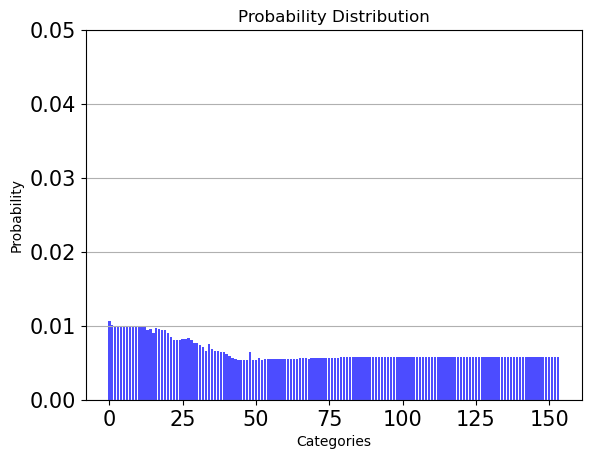

In [32]:
# Drift setting alpha = 0.3, unform drift
init_prob = find_q(prob, 0.3, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [33]:
bulkloading_n = int(0.5 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 1006, sample_n: 475231, bound_n: 11973
Exceeding the number of keys in bin 1007, sample_n: 452240, bound_n: 43146
Exceeding the number of keys in bin 1008, sample_n: 447927, bound_n: 48879
Exceeding the number of keys in bin 1009, sample_n: 447538, bound_n: 49394
Exceeding the number of keys in bin 1010, sample_n: 438975, bound_n: 60659
Exceeding the number of keys in bin 1011, sample_n: 440629, bound_n: 58495
Exceeding the number of keys in bin 1012, sample_n: 439703, bound_n: 59708
Exceeding the number of keys in bin 1013, sample_n: 444685, bound_n: 53164
Exceeding the number of keys in bin 1014, sample_n: 444833, bound_n: 52969
Exceeding the number of keys in bin 1015, sample_n: 440523, bound_n: 58634
Exceeding the number of keys in bin 1016, sample_n: 446530, bound_n: 50727
Exceeding the number of keys in bin 1017, sample_n: 436740, bound_n: 63576
Exceeding the number of keys in bin 1018, sample_n: 436269, bound_n: 64190
Exceeding the number of k

Total number of bins: 154


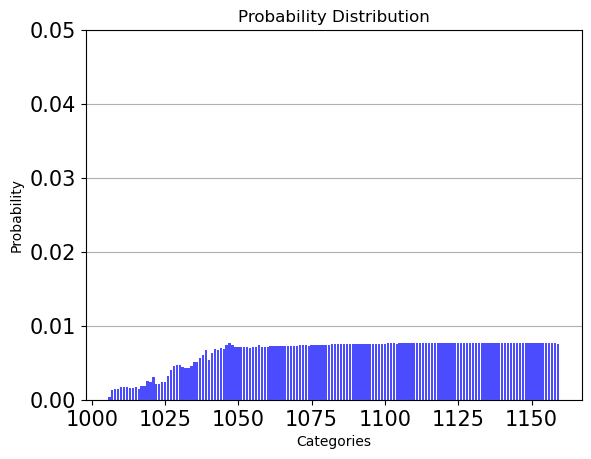

In [34]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 20
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

In [35]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))
# print bulkloading key CDF

Insert number of records: 56507684
Insert ratio: 0.6248291863604382


In [36]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.1


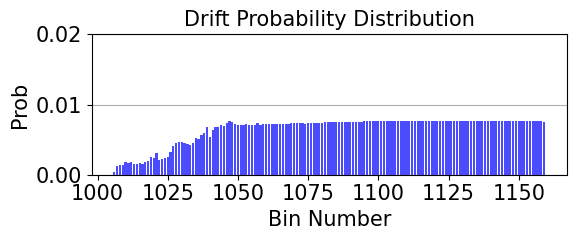

In [37]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 10) / 10
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('Bin Number', fontsize = 15)
ax.set_ylabel('Prob', fontsize = 15)
ax.set_title('Drift Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, 0.02)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/wiki_ts_200M_uint64_distribution_drift_03.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [38]:
workload_dir_path = "/users/lingze/neurbench/data/workload/wiki_ts_200M_uint64_drift_03"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

---
### Drift 0.5

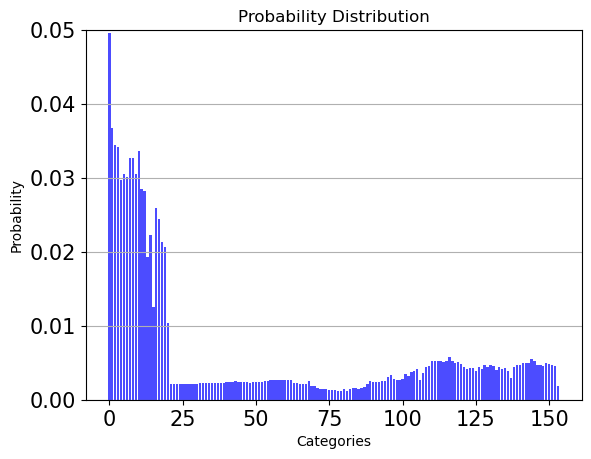

In [39]:
# Drift setting alpha = 0.5, unform drift
init_prob = find_q(prob, 0.5, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [40]:
bulkloading_n = int(0.7*len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 1006, sample_n: 3103334, bound_n: 11973
Exceeding the number of keys in bin 1007, sample_n: 2295819, bound_n: 43146
Exceeding the number of keys in bin 1008, sample_n: 2150824, bound_n: 48879
Exceeding the number of keys in bin 1009, sample_n: 2137845, bound_n: 49394
Exceeding the number of keys in bin 1010, sample_n: 1855600, bound_n: 60659
Exceeding the number of keys in bin 1011, sample_n: 1909593, bound_n: 58495
Exceeding the number of keys in bin 1012, sample_n: 1879316, bound_n: 59708
Exceeding the number of keys in bin 1013, sample_n: 2043045, bound_n: 53164
Exceeding the number of keys in bin 1014, sample_n: 2047940, bound_n: 52969
Exceeding the number of keys in bin 1015, sample_n: 1906122, bound_n: 58634
Exceeding the number of keys in bin 1016, sample_n: 2104283, bound_n: 50727
Exceeding the number of keys in bin 1017, sample_n: 1782966, bound_n: 63576
Exceeding the number of keys in bin 1018, sample_n: 1767696, bound_n: 64190
Exceeding th

Total number of bins: 154


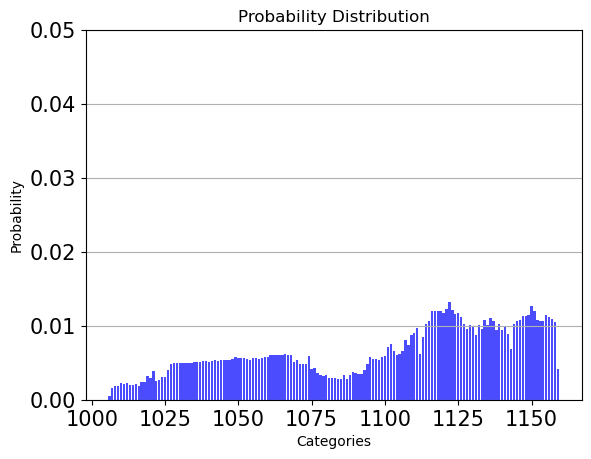

In [41]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 20
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

In [42]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))
# print bulkloading key CDF

Insert number of records: 63365625
Insert ratio: 0.7006603192580082


In [43]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.1


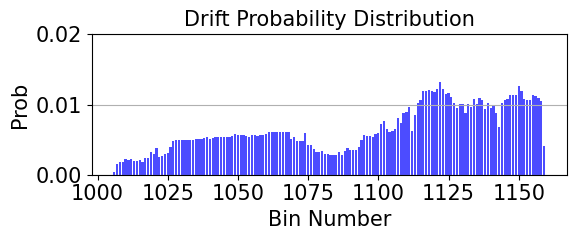

In [44]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 10) / 10
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('Bin Number', fontsize = 15)
ax.set_ylabel('Prob', fontsize = 15)
ax.set_title('Drift Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, 0.02)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/wiki_ts_200M_uint64_distribution_drift_05.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [45]:
workload_dir_path = "/users/lingze/neurbench/data/workload/wiki_ts_200M_uint64_drift_05"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

---
### Drift 0.7

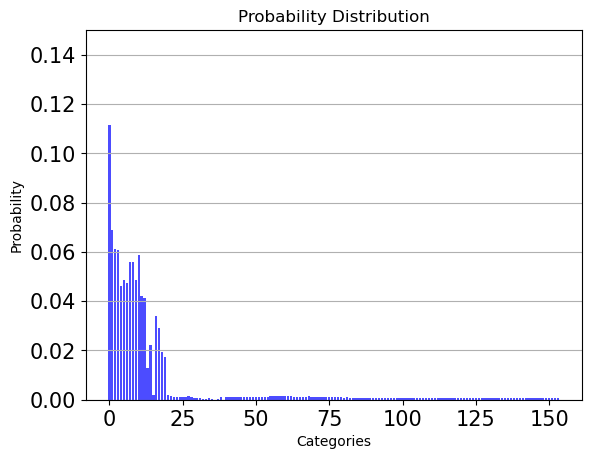

In [46]:
# Drift setting alpha = 0.7, unform drift
init_prob = find_q(prob, 0.7, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [47]:
bulkloading_n = int( 1 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 1006, sample_n: 9953209, bound_n: 11973
Exceeding the number of keys in bin 1007, sample_n: 6154592, bound_n: 43146
Exceeding the number of keys in bin 1008, sample_n: 5476735, bound_n: 48879
Exceeding the number of keys in bin 1009, sample_n: 5416146, bound_n: 49394
Exceeding the number of keys in bin 1010, sample_n: 4103086, bound_n: 60659
Exceeding the number of keys in bin 1011, sample_n: 4353522, bound_n: 58495
Exceeding the number of keys in bin 1012, sample_n: 4213040, bound_n: 59708
Exceeding the number of keys in bin 1013, sample_n: 4974111, bound_n: 53164
Exceeding the number of keys in bin 1014, sample_n: 4996911, bound_n: 52969
Exceeding the number of keys in bin 1015, sample_n: 4337411, bound_n: 58634
Exceeding the number of keys in bin 1016, sample_n: 5259549, bound_n: 50727
Exceeding the number of keys in bin 1017, sample_n: 3766842, bound_n: 63576
Exceeding the number of keys in bin 1018, sample_n: 3696260, bound_n: 64190
Exceeding th

Total number of bins: 154


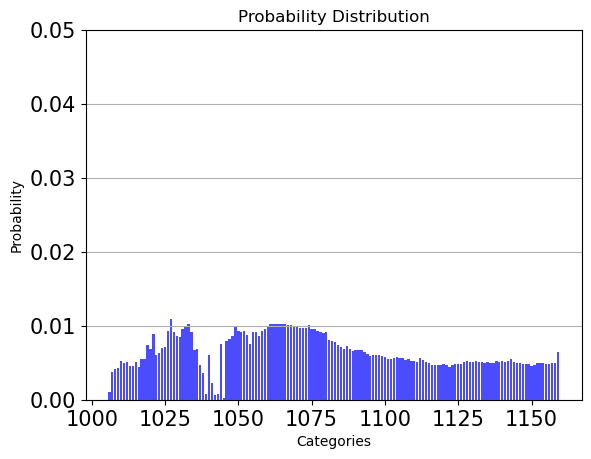

In [48]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 20
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

In [49]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))
# print bulkloading key CDF

Insert number of records: 78816298
Insert ratio: 0.8715048974805237


In [50]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.1


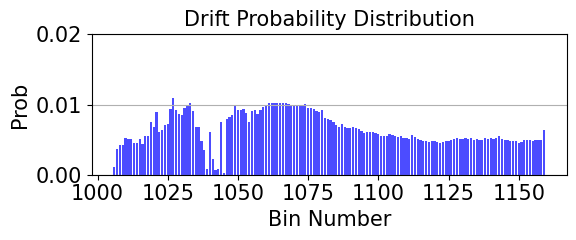

In [51]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 10) / 10
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('Bin Number', fontsize = 15)
ax.set_ylabel('Prob', fontsize = 15)
ax.set_title('Drift Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, 0.02)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/wiki_ts_200M_uint64_distribution_drift_07.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [52]:
workload_dir_path = "/users/lingze/neurbench/data/workload/wiki_ts_200M_uint64_drift_07"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)